In [53]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from sklearn.decomposition import PCA

In [54]:
x_test_scaled = pd.read_csv('260_sample_test_scaled.csv').set_index("Patient_ID")
# x_test_scaled = x_test_scaled.set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [55]:
test_set = x_test_scaled.copy()

In [56]:
# https://www.datacamp.com/tutorial/principal-component-analysis-in-python

def encode_pca(dataset):
    comp_cols = np.asarray(np.arange(32), dtype=str)
    pca_x_test = PCA(n_components=32)
    principalComponents_x_test = pca_x_test.fit_transform(dataset)
    pca_x_test_ds = pd.DataFrame(data = principalComponents_x_test, 
                                       columns = comp_cols, index=dataset.index)
    return pca_x_test_ds, pca_x_test

tsne_dataset, pca_x_test = encode_pca(test_set)

In [57]:
print('Explained variation per principal component: {}'.format(pca_x_test.explained_variance_ratio_))
print("Total variance explained:",np.sum(pca_x_test.explained_variance_ratio_))

Explained variation per principal component: [0.58789216 0.07864964 0.05321548 0.04513818 0.03019029 0.01978823
 0.01549283 0.01338982 0.01120262 0.01049712 0.00967305 0.00775334
 0.00710395 0.00696553 0.0058972  0.00578172 0.0054264  0.00521537
 0.00479695 0.00458293 0.00409328 0.00361395 0.00355702 0.00337007
 0.00316917 0.00307437 0.00301912 0.00259887 0.00250751 0.00239117
 0.00228131 0.00202056]
Total variance explained: 0.9643492097643027


In [58]:
tsne_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,-2.947570,0.188482,0.100641,0.381468,-0.867942,0.037972,-0.349832,-0.154516,-0.018607,-0.458834,...,-0.110902,0.262835,0.018625,0.081471,-0.143111,0.197925,0.190537,0.017444,-0.031561,0.409541
105_CD_plain,-2.137376,0.994852,0.419276,-0.074156,0.418213,-0.130395,-0.425872,0.519719,0.392787,0.046846,...,0.288709,0.072650,-0.382261,0.180394,0.261511,0.021013,-0.146097,-0.190971,-0.014439,-0.065328
2_CD_plain,4.461536,-1.228947,-0.019268,1.794078,-0.259040,0.142568,-1.026315,1.041566,-0.107882,0.037725,...,-0.204960,0.126075,-0.142689,-0.046999,0.045515,-0.000622,-0.067881,0.085187,0.006213,-0.038396
184_CD_plain,0.003861,0.630354,-0.569237,-0.447470,0.375968,0.162263,-0.129301,-0.453713,0.413206,-0.426879,...,-0.058915,0.128821,0.045742,-0.001113,-0.081530,0.062949,-0.016022,0.127285,0.073943,-0.092703
312_CD_plain,-0.673224,-0.352022,-0.516608,-0.642397,0.242147,0.083958,0.126032,-0.357213,0.318324,0.437952,...,-0.049471,-0.264481,-0.214035,0.068770,0.059980,0.136014,-0.158014,0.048132,-0.312824,0.046127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,-0.609080,-0.953039,0.016015,0.142899,0.777012,-0.625771,0.260263,-0.147999,-0.367601,0.098115,...,-0.064723,-0.101589,-0.121169,0.197379,-0.322125,-0.088662,-0.105338,-0.310786,-0.342882,-0.059237
279_CD_plain,3.537938,-1.060687,1.638088,-0.328551,-0.980174,-0.197260,0.488113,-0.345031,-0.174888,-0.113366,...,0.034290,-0.029468,-0.096228,0.123509,-0.246924,0.230044,-0.076436,0.291526,0.148813,-0.028112
179_CD_plain,-1.291015,-0.577115,-0.766027,-0.035352,0.158982,-0.147463,0.116490,-0.001241,0.116490,0.297870,...,-0.198897,-0.012404,0.009162,0.106277,-0.054256,-0.142465,0.140946,0.088003,0.206953,0.018994


## Labels

In [59]:
patient_ids = np.array(tsne_dataset.index)
patient_ids

array(['253_CD_plain', '105_CD_plain', '2_CD_plain', '184_CD_plain',
       '312_CD_plain', '271_CD_plain', '62_CD_deep_ulcer',
       '167_CD_deep_ulcer', '196_CD_deep_ulcer', '34_control',
       '23_CD_deep_ulcer', '58_CD_plain', '197_CD_plain',
       '93_CD_deep_ulcer', '229_CD_deep_ulcer', '293_CD_plain',
       '192_CD_plain', '52_CD_plain', '46_CD_deep_ulcer', '268_CD_plain',
       '176_CD_deep_ulcer', '228_CD_plain', '215_CD_plain',
       '307_CD_plain', '49_CD_deep_ulcer', '183_CD_deep_ulcer',
       '191_CD_plain', '270_CD_plain', '41_control', '78_control',
       '50_CD_deep_ulcer', '236_CD_deep_ulcer', '206_CD_plain',
       '19_control', '211_CD_plain', '47_CD_plain', '262_CD_plain',
       '82_control', '161_CD_plain', '137_CD_plain', '180_control',
       '260_CD_deep_ulcer', '134_CD_plain', '289_CD_plain',
       '314_CD_plain', '177_CD_deep_ulcer', '212_CD_deep_ulcer',
       '118_control', '112_CD_plain', '132_CD_plain', '40_CD_plain',
       '230_CD_deep_ulcer', 

In [60]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels = vec(patient_ids)
disease_labels

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1,
       1, 2, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1,
       0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2])

## tSNE plots

In [61]:
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

In [62]:
no_IBD = disease_labels == 0
CD_no_ulcer = disease_labels == 1
CD_deep_ulcer = disease_labels == 2
UC = disease_labels == 3

In [63]:
no_IBD.shape

(78,)

In [64]:
tsne_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,-2.947570,0.188482,0.100641,0.381468,-0.867942,0.037972,-0.349832,-0.154516,-0.018607,-0.458834,...,-0.110902,0.262835,0.018625,0.081471,-0.143111,0.197925,0.190537,0.017444,-0.031561,0.409541
105_CD_plain,-2.137376,0.994852,0.419276,-0.074156,0.418213,-0.130395,-0.425872,0.519719,0.392787,0.046846,...,0.288709,0.072650,-0.382261,0.180394,0.261511,0.021013,-0.146097,-0.190971,-0.014439,-0.065328
2_CD_plain,4.461536,-1.228947,-0.019268,1.794078,-0.259040,0.142568,-1.026315,1.041566,-0.107882,0.037725,...,-0.204960,0.126075,-0.142689,-0.046999,0.045515,-0.000622,-0.067881,0.085187,0.006213,-0.038396
184_CD_plain,0.003861,0.630354,-0.569237,-0.447470,0.375968,0.162263,-0.129301,-0.453713,0.413206,-0.426879,...,-0.058915,0.128821,0.045742,-0.001113,-0.081530,0.062949,-0.016022,0.127285,0.073943,-0.092703
312_CD_plain,-0.673224,-0.352022,-0.516608,-0.642397,0.242147,0.083958,0.126032,-0.357213,0.318324,0.437952,...,-0.049471,-0.264481,-0.214035,0.068770,0.059980,0.136014,-0.158014,0.048132,-0.312824,0.046127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,-0.609080,-0.953039,0.016015,0.142899,0.777012,-0.625771,0.260263,-0.147999,-0.367601,0.098115,...,-0.064723,-0.101589,-0.121169,0.197379,-0.322125,-0.088662,-0.105338,-0.310786,-0.342882,-0.059237
279_CD_plain,3.537938,-1.060687,1.638088,-0.328551,-0.980174,-0.197260,0.488113,-0.345031,-0.174888,-0.113366,...,0.034290,-0.029468,-0.096228,0.123509,-0.246924,0.230044,-0.076436,0.291526,0.148813,-0.028112
179_CD_plain,-1.291015,-0.577115,-0.766027,-0.035352,0.158982,-0.147463,0.116490,-0.001241,0.116490,0.297870,...,-0.198897,-0.012404,0.009162,0.106277,-0.054256,-0.142465,0.140946,0.088003,0.206953,0.018994


dataset size: (78, 32)


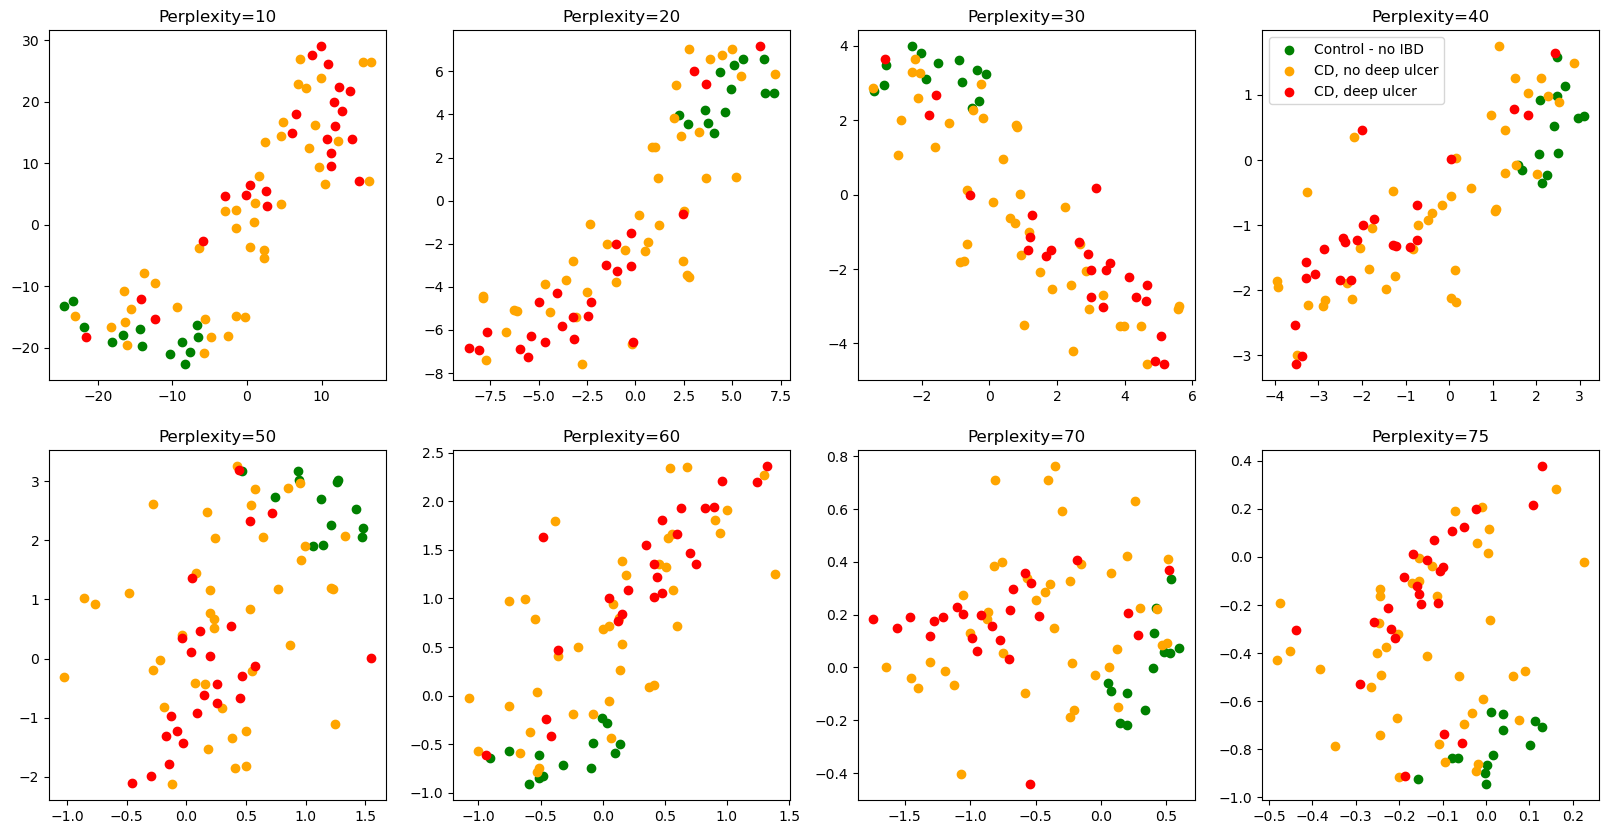

In [65]:
def plot_tsne(tsne_dataset, selected_patient_idx=None):
    n_samples = 78
    n_components = 2
    print("dataset size:",tsne_dataset.shape)

    (fig, subplots) = plt.subplots(2, 4, figsize=(20, 10))
    perplexities = [10, 20, 30, 40]

    for i, perplexity in enumerate(perplexities):
        ax = subplots[0][i]

        t0 = time()
        tsne = manifold.TSNE(
            n_components=n_components,
            init="random",
            random_state=0,
            perplexity=perplexity,
            n_iter=750,
            method='exact'
        )
        Y = tsne.fit_transform(tsne_dataset)
        t1 = time()
        ax.set_title("Perplexity=%d" % perplexity)
        ax.scatter(Y[no_IBD, 0], Y[no_IBD, 1], c="g", label="Control - no IBD")
        ax.scatter(Y[CD_no_ulcer, 0], Y[CD_no_ulcer, 1], c="orange", label="CD, no deep ulcer")
        ax.scatter(Y[CD_deep_ulcer, 0], Y[CD_deep_ulcer, 1], c="r", label="CD, deep ulcer")
        
        if selected_patient_idx is not None:
            ax.scatter(Y[selected_patient_idx, 0], Y[selected_patient_idx, 1], c="cyan", s=500, marker='*',edgecolor='black', linewidth=.7, label="Selected patient")
    #     ax.scatter(Y[UC, 0], Y[UC, 1], c="brown", label="UC")

        if i == 3:
            ax.legend()

        ax.axis("tight")

    perplexities = [50, 60, 70, 75]
    for i, perplexity in enumerate(perplexities):
        ax = subplots[1][i]

        t0 = time()
        tsne = manifold.TSNE(
            n_components=n_components,
            init="random",
            random_state=0,
            perplexity=perplexity,
            n_iter=1000,
            method='exact'
        )
        Y = tsne.fit_transform(tsne_dataset)
        t1 = time()
        ax.set_title("Perplexity=%d" % perplexity)
        ax.scatter(Y[no_IBD, 0], Y[no_IBD, 1], c="g")
        ax.scatter(Y[CD_no_ulcer, 0], Y[CD_no_ulcer, 1], c="orange")
        ax.scatter(Y[CD_deep_ulcer, 0], Y[CD_deep_ulcer, 1], c="r")
        
        if selected_patient_idx is not None:
            ax.scatter(Y[selected_patient_idx, 0], Y[selected_patient_idx, 1], c="cyan", s=500, marker='*',edgecolor='black', linewidth=.7, label="Selected patient")
    #     ax.scatter(Y[UC, 0], Y[UC, 1], c="brown", label="UC")

        ax.axis("tight")

plot_tsne(tsne_dataset)

# Class contrastive explainability

## Gene expression distributions of test set (post scaling)

In [66]:
# tsne_dataset

In [67]:
hundred_control = x_test_scaled.loc[x_test_scaled.index.str.endswith('_control')]
hundred_CD_plain = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_plain')]
hundred_CD_deep_ulcer = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_deep_ulcer')]
datasets = [hundred_control, hundred_CD_plain, hundred_CD_deep_ulcer]
labels = ["Control", "Crohn's Disease", "Crohn's Disease Deep Ulcer"]
colours = ["green", "orange", "red"]

In [68]:
# import matplotlib.pyplot as plt
# import scipy.stats as stats
# import math

# for gene_symbol in hundred_control.columns:
#     for i in range(len(datasets)):
#         ds = datasets[i]
#         label = labels[i]
#         colour = colours[i]
#         vals = ds[gene_symbol].values
#         gene_stats = ds.describe()
#         g_mean = gene_stats.loc["mean", gene_symbol]
#         g_std = gene_stats.loc["std", gene_symbol]
#         g_min = gene_stats.loc["min", gene_symbol]
#         g_max = gene_stats.loc["max", gene_symbol]

#         mu = g_mean
#         variance = g_std**2
#         sigma = math.sqrt(variance)
#         x = np.linspace(g_min, g_max, 100)
#         plt.plot(x, stats.norm.pdf(x, mu, sigma), label=label, c=colour)

#         if i<4:
#             plt.hist(vals, bins=25, density=True, alpha=0.6, color=colour)
#     plt.title(gene_symbol+" Distributions")
#     plt.xlabel('Gene expression (FPKM)')
#     plt.ylabel('Probability density')
#     plt.legend()
#     plt.show()

## CD Deep Ulcer patient

In [69]:
test_set = x_test_scaled.copy()
test_set

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [70]:
# pid = '212_CD_deep_ulcer'
def get_patient(symptom, frac=2):
    poss_patients = test_set.loc[test_set.index.str.endswith(symptom)]
    print(len(poss_patients),"possible")
    selected_patient = poss_patients.iloc[[len(poss_patients)//frac]]
    pid = selected_patient.index[0]
    return selected_patient, pid

selected_patient, pid = get_patient('CD_deep_ulcer')
selected_patient

24 possible


,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.327476,0.256429,0.0,0.787863,0.559487,0.0,0.363882,0.283622,0.0,0.0


In [71]:
pid

'260_CD_deep_ulcer'

In [72]:
ind = tsne_dataset.index
selected_patient_idx = ind.get_loc(pid)


dataset size: (78, 32)


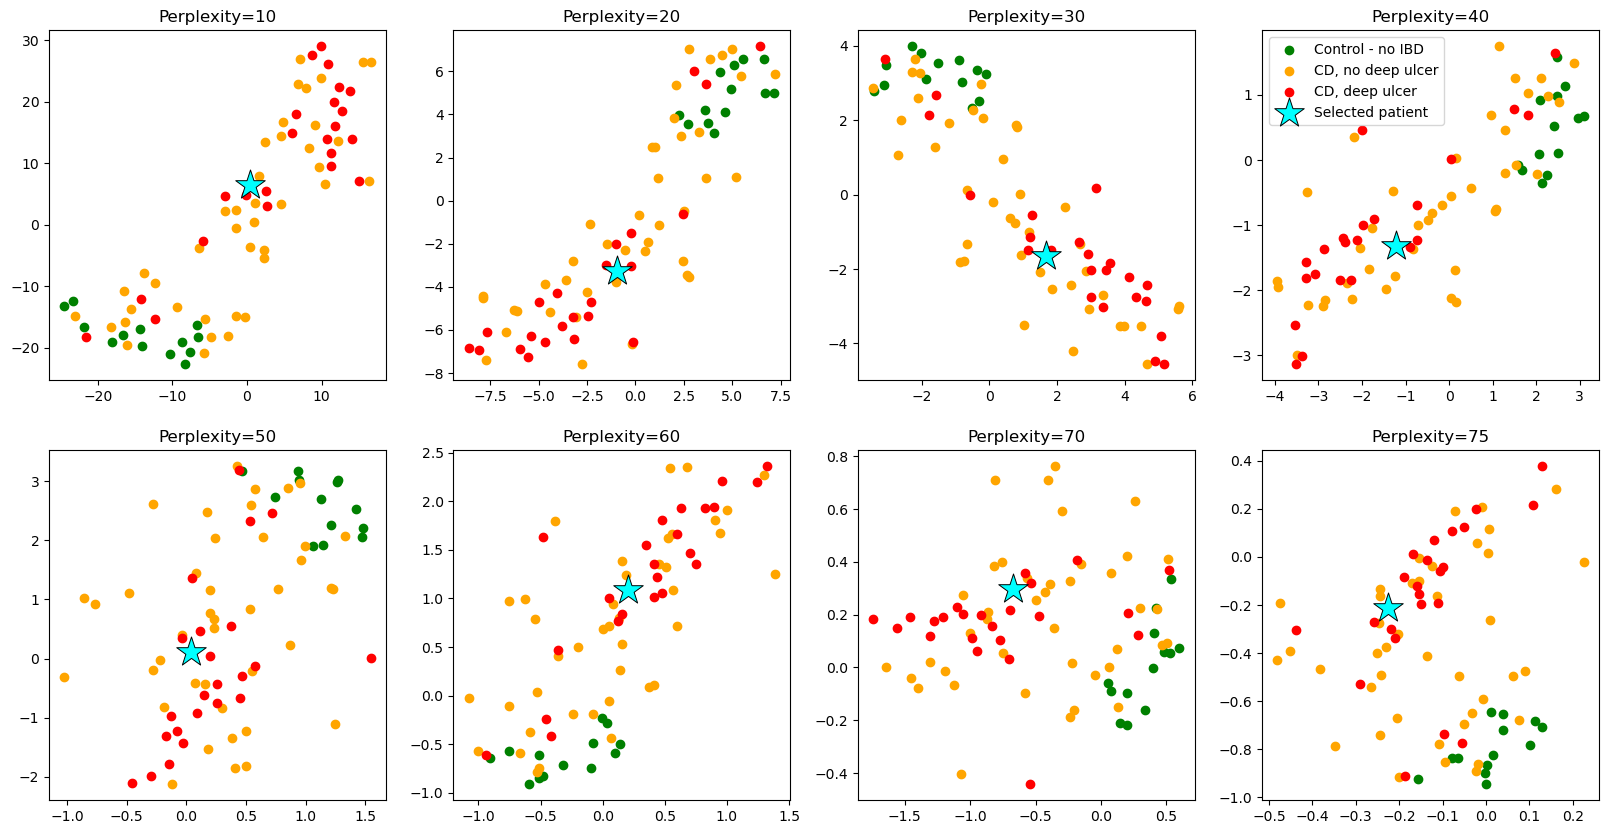

In [73]:


plot_tsne(tsne_dataset, selected_patient_idx)

### Modify gene expressions for the selected patient - 60 genes

In [74]:
test_set = x_test_scaled.copy()

selected_patient = test_set.loc[test_set.index.str.startswith(pid)]
selected_patient

# selected_patient, pid = get_patient('CD_deep_ulcer')
# selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.327476,0.256429,0.0,0.787863,0.559487,0.0,0.363882,0.283622,0.0,0.0


In [75]:
with open("most_diff_genes_60", "rb") as fp:   # Unpickling
    most_diff_genes_60 = pickle.load(fp)

In [76]:
def modify_expression(pid, most_diff_genes, dataset):
    print("dataset size (should be test):",dataset.shape)
    controls = dataset.loc[dataset.index.str.endswith('_control')]
#     plains = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_plain')]
#     ulcers = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_deep_ulcer')]
    
    for gene_symbol in most_diff_genes:
        new_val = controls.describe().loc["mean", gene_symbol]
        dataset.loc[dataset.index.str.startswith(pid), gene_symbol] = new_val
    return dataset



In [77]:
test_set.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

In [78]:
test_set = modify_expression(pid, most_diff_genes_60, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

dataset size (should be test): (78, 219)


,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.837271,0.625309,0.800854,0.834515,0.740914,0.578012,0.638968,0.173455,0.313654,0.836045,...,0.327476,0.256429,0.0,0.787863,0.559487,0.0,0.363882,0.283622,0.0,0.0


## Re-encoding the dataset

In [79]:
tsne_dataset, pca_x_test = encode_pca(test_set)
tsne_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,-2.925279,0.182552,0.104389,0.402376,-0.860331,0.040653,0.323144,-0.204937,-0.013896,-0.420777,...,-0.046380,-0.286528,-0.024807,0.001738,-0.140779,0.211438,0.082948,0.208654,-0.004514,-0.127434
105_CD_plain,-2.115507,0.991462,0.428139,-0.074033,0.412767,-0.153526,0.484948,0.450970,0.413554,0.010451,...,0.077111,0.030503,0.234693,0.435662,0.207085,-0.038612,0.025486,-0.222041,0.136030,0.032229
2_CD_plain,4.494185,-1.191173,-0.081869,1.800125,-0.237955,0.111943,1.134520,0.872417,-0.059506,-0.082850,...,-0.110599,-0.218895,-0.080944,0.154108,-0.001743,-0.072995,0.038166,-0.063623,-0.091071,0.117599
184_CD_plain,0.020712,0.624268,-0.560023,-0.486957,0.361883,0.165985,0.078021,-0.464506,0.413805,-0.361999,...,-0.284620,-0.122286,0.056495,-0.099899,-0.048455,0.073632,0.083957,0.052901,-0.059271,0.104486
312_CD_plain,-0.653210,-0.360928,-0.493247,-0.665918,0.228021,0.085367,-0.154420,-0.311117,0.296554,0.465313,...,-0.071895,0.177266,-0.079513,0.273426,0.010689,-0.021053,0.176565,-0.172589,-0.186819,-0.194406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,-0.582347,-0.948899,0.017166,0.146500,0.781628,-0.621868,-0.272728,-0.091805,-0.381240,0.102332,...,0.046024,0.073888,-0.042808,0.185591,-0.337920,0.187008,-0.176326,-0.270449,0.016074,-0.335750
279_CD_plain,3.567900,-1.041802,1.645785,-0.253419,-0.968225,-0.170167,-0.542697,-0.321609,-0.170223,-0.118457,...,-0.090242,0.093557,0.153785,0.053900,-0.219303,0.098709,0.326712,0.074507,-0.091869,0.200274
179_CD_plain,-1.269183,-0.587896,-0.748659,-0.052724,0.153784,-0.156097,-0.102457,0.054956,0.095226,0.311896,...,0.081632,-0.068255,-0.084475,0.018921,-0.033183,0.152948,-0.190693,0.160547,-0.034657,0.234499


## Replot tSNE

dataset size: (78, 32)


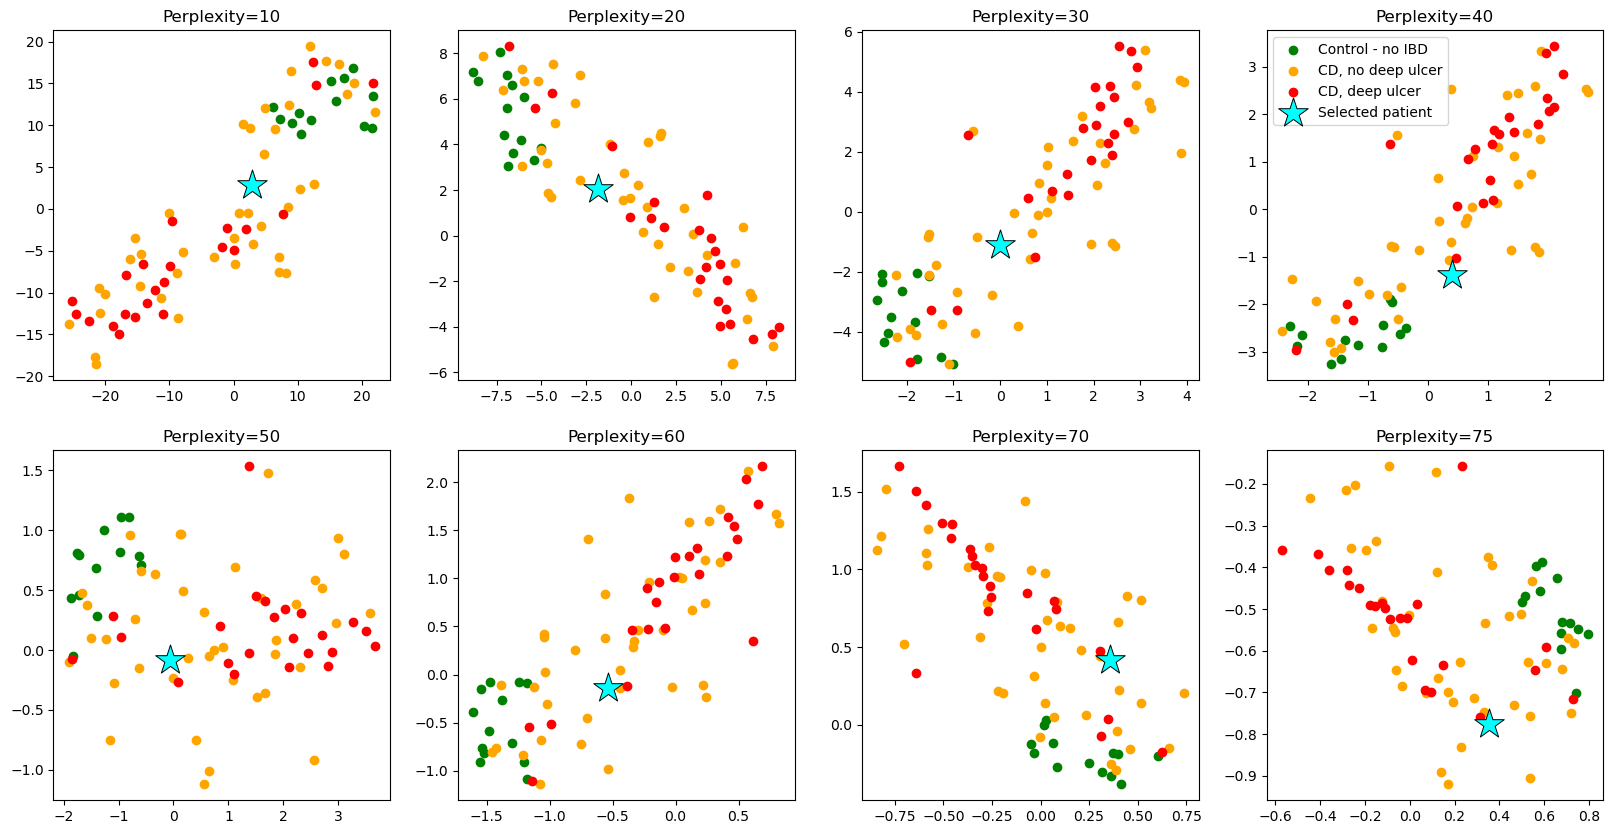

In [80]:


plot_tsne(tsne_dataset, selected_patient_idx)

### Modify gene expressions for the selected patient - 120 genes

In [81]:
test_set = x_test_scaled.copy()

selected_patient = test_set.loc[test_set.index.str.startswith(pid)]
selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.327476,0.256429,0.0,0.787863,0.559487,0.0,0.363882,0.283622,0.0,0.0


In [82]:

# selected_patient = tsne_dataset.loc[tsne_dataset.index.str.startswith(pid)]
# selected_patient

In [83]:
with open("most_diff_genes_115", "rb") as fp:   # Unpickling
    most_diff_genes = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [84]:
test_set = modify_expression(pid, most_diff_genes, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

dataset size (should be test): (78, 219)


,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.327476,0.256429,0.0,0.787863,0.559487,0.0,0.363882,0.283622,0.0,0.0


## Re-encoding the dataset

In [85]:
tsne_dataset, pca_x_test = encode_pca(test_set)
tsne_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,-2.947620,0.186595,0.103072,0.389432,-0.863976,0.037285,-0.348146,-0.155441,-0.023501,-0.451162,...,-0.075428,-0.270480,0.009769,0.113877,-0.082374,0.244941,0.177274,0.032875,0.029435,0.404845
105_CD_plain,-2.137330,0.995053,0.418616,-0.074718,0.417022,-0.127487,-0.427575,0.520827,0.394132,0.042522,...,0.300652,-0.009267,-0.398395,0.101784,0.271561,0.005610,-0.149715,-0.173915,0.028097,-0.084595
2_CD_plain,4.462112,-1.224724,-0.026208,1.798371,-0.248303,0.144090,-1.030155,1.033035,-0.102222,0.026637,...,-0.176258,-0.142995,-0.144303,-0.026857,0.023461,-0.035307,-0.077642,0.087752,-0.013901,-0.037679
184_CD_plain,0.004159,0.630168,-0.570008,-0.456151,0.369618,0.161935,-0.127664,-0.456361,0.415007,-0.427566,...,-0.039890,-0.143460,0.055284,0.037418,-0.062091,0.041373,-0.024041,0.130049,-0.077434,-0.099700
312_CD_plain,-0.672898,-0.353146,-0.513757,-0.647291,0.235843,0.084343,0.126194,-0.355164,0.322422,0.435200,...,-0.081268,0.264781,-0.198805,0.073593,0.064617,0.084337,-0.189566,0.086133,0.305462,0.052199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,-0.608218,-0.949131,0.011190,0.136788,0.778408,-0.626777,0.260625,-0.146905,-0.366684,0.096355,...,-0.075767,0.091042,-0.064804,0.314420,-0.236491,-0.055769,-0.075398,-0.301721,0.369420,-0.062277
279_CD_plain,3.538564,-1.057623,1.641607,-0.315311,-0.977470,-0.201149,0.487353,-0.350672,-0.167493,-0.122529,...,0.039541,0.026438,-0.042496,0.223838,-0.195884,0.164563,-0.126027,0.318977,-0.166420,-0.049378
179_CD_plain,-1.290638,-0.577750,-0.765774,-0.039945,0.157264,-0.147309,0.117052,0.000048,0.115660,0.296677,...,-0.207553,-0.017265,0.030423,0.135972,0.000803,-0.117115,0.173345,0.046067,-0.211455,0.030942


## Replot tSNE

dataset size: (78, 32)


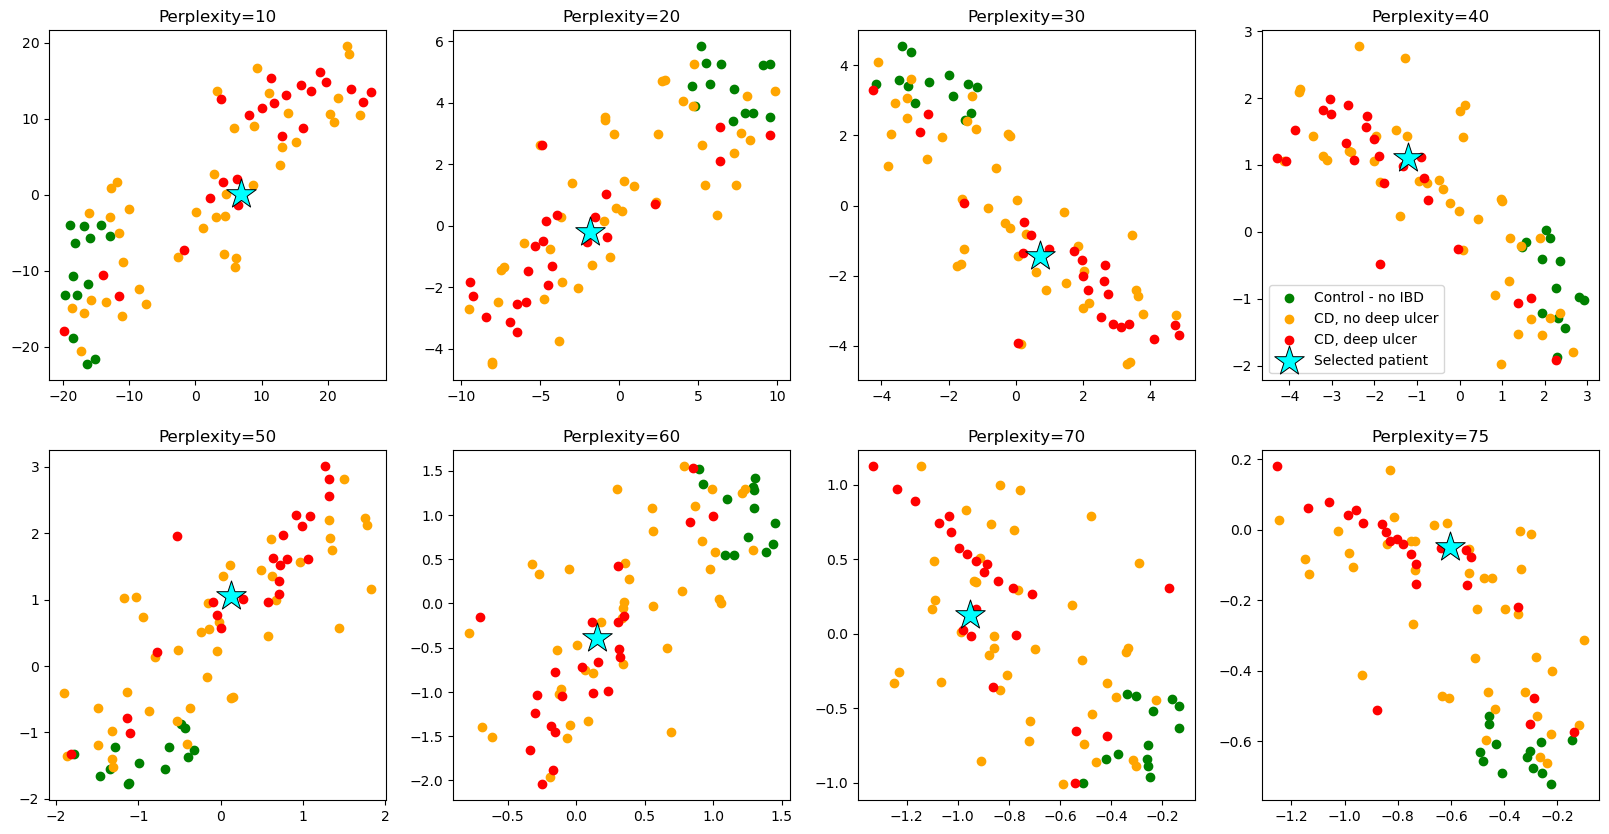

In [86]:


plot_tsne(tsne_dataset, selected_patient_idx)

Patient moves into the control cluster

## CD No Deep Ulcer patient

In [87]:
test_set = x_test_scaled.copy()
test_set

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [88]:


selected_patient, pid = get_patient('CD_plain', 6)
selected_patient

41 possible


,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [89]:
pid

'58_CD_plain'

In [90]:
ind = tsne_dataset.index
selected_patient_idx = ind.get_loc(pid)


dataset size: (78, 32)


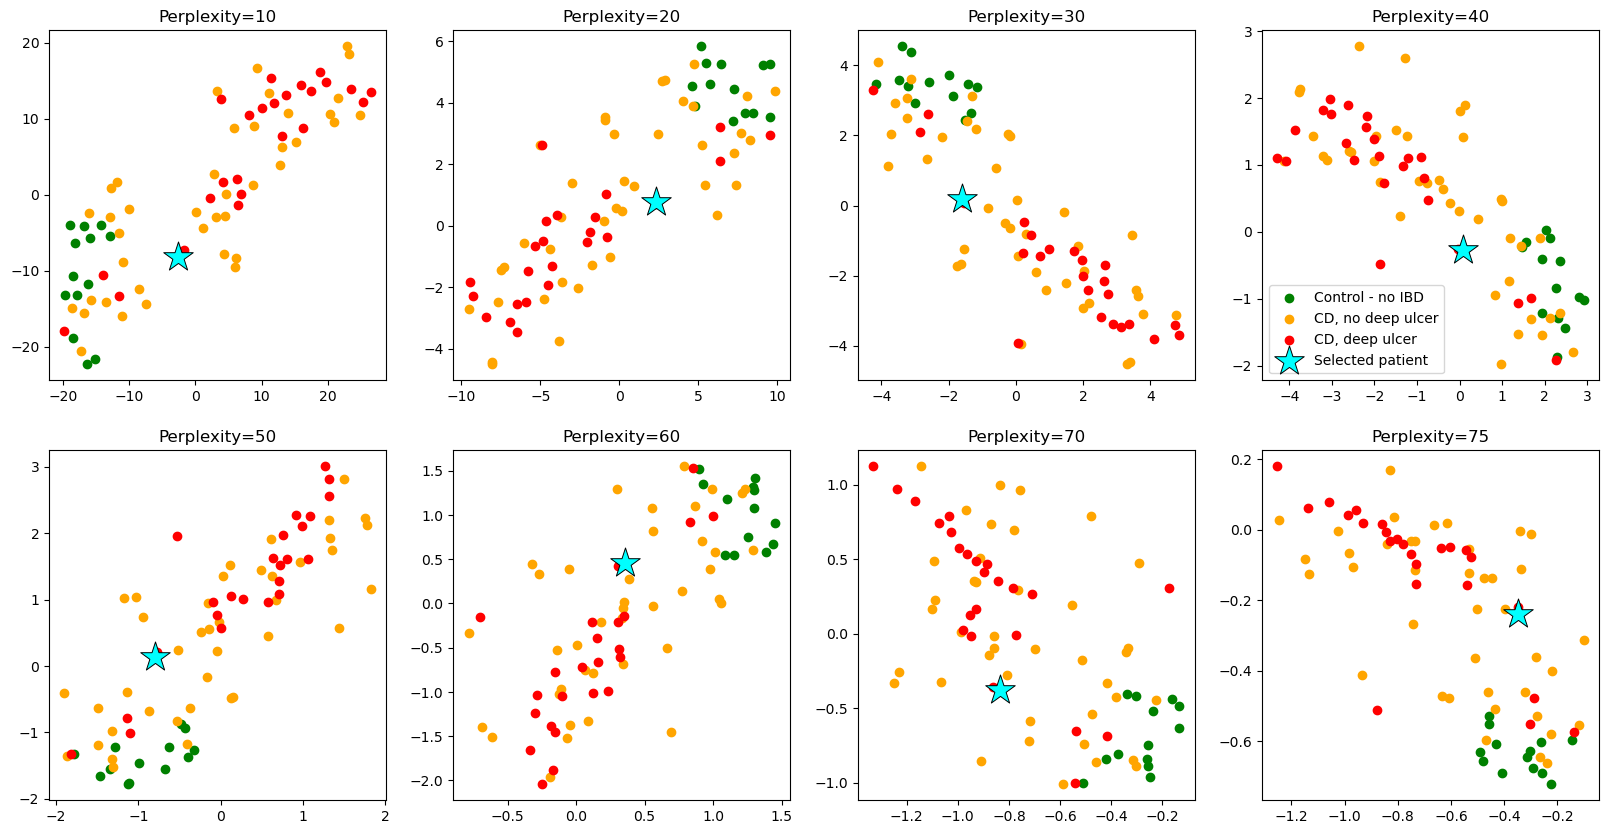

In [91]:


plot_tsne(tsne_dataset, selected_patient_idx)

### Modify gene expressions for the selected patient - 60 genes

In [92]:
test_set = x_test_scaled.copy()

selected_patient = test_set.loc[test_set.index.str.startswith(pid)]
selected_patient

# selected_patient, pid = get_patient('CD_deep_ulcer')
# selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [93]:
with open("most_diff_genes_60", "rb") as fp:   # Unpickling
    most_diff_genes_60 = pickle.load(fp)

In [94]:
def modify_expression(pid, most_diff_genes, dataset):
    print("dataset size (should be test):",dataset.shape)
    controls = dataset.loc[dataset.index.str.endswith('_control')]
#     plains = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_plain')]
#     ulcers = x_test_scaled.loc[x_test_scaled.index.str.endswith('_CD_deep_ulcer')]
    
    for gene_symbol in most_diff_genes:
        new_val = controls.describe().loc["mean", gene_symbol]
        dataset.loc[dataset.index.str.startswith(pid), gene_symbol] = new_val
    return dataset



In [95]:
test_set.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

In [96]:
test_set = modify_expression(pid, most_diff_genes_60, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

dataset size (should be test): (78, 219)


,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.837271,0.67885,0.800854,0.834515,0.740914,0.498697,0.638968,0.173455,0.313654,0.836045,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


## Re-encoding the dataset

In [97]:
tsne_dataset, pca_x_test = encode_pca(test_set)
tsne_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,-2.938074,0.186826,0.100920,0.388089,-0.869971,-0.002498,0.345097,-0.151416,-0.050822,-0.459303,...,-0.164320,0.238949,-0.005855,0.082489,-0.065675,-0.291529,0.058606,0.143575,0.015869,0.318193
105_CD_plain,-2.126290,1.013352,0.411144,-0.093928,0.391182,-0.152022,0.443548,0.520864,0.371626,0.004179,...,0.407739,0.114761,-0.275132,0.089918,0.331386,-0.093125,0.014888,-0.255288,0.037225,-0.059283
2_CD_plain,4.470625,-1.217936,-0.020472,1.802386,-0.217874,0.125788,1.096329,0.972090,-0.089200,0.033468,...,-0.289987,0.098038,-0.198181,0.023877,0.067061,0.139331,0.037719,-0.002184,-0.018086,0.059670
184_CD_plain,0.013552,0.639135,-0.573580,-0.463441,0.336754,0.152315,0.097628,-0.445537,0.379206,-0.483693,...,-0.228973,0.118212,0.021234,0.058591,-0.072845,0.046730,0.082766,0.073831,-0.098460,-0.006938
312_CD_plain,-0.663766,-0.349455,-0.514759,-0.648230,0.228913,0.089586,-0.139711,-0.343371,0.394147,0.386158,...,-0.035459,-0.256304,-0.189912,0.146028,0.093321,0.148517,0.219640,-0.019314,0.301738,0.067546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,-0.599124,-0.944227,0.016971,0.138191,0.827881,-0.580375,-0.241784,-0.147025,-0.307841,0.128673,...,-0.039035,-0.105362,-0.093040,0.302518,-0.200304,-0.095330,-0.109990,-0.293458,0.385452,-0.007392
279_CD_plain,3.545774,-1.068370,1.648298,-0.298303,-0.957182,-0.203097,-0.524965,-0.322974,-0.223788,-0.073087,...,0.006266,-0.009949,-0.046919,0.261785,-0.197089,0.066409,0.297653,0.179917,-0.204163,0.004770
179_CD_plain,-1.281190,-0.573442,-0.765035,-0.040458,0.166749,-0.142509,-0.109398,0.015040,0.154906,0.282678,...,-0.137362,-0.035566,0.004188,0.090192,0.009465,-0.036280,-0.198607,0.094301,-0.218239,0.017271


## Replot tSNE

dataset size: (78, 32)


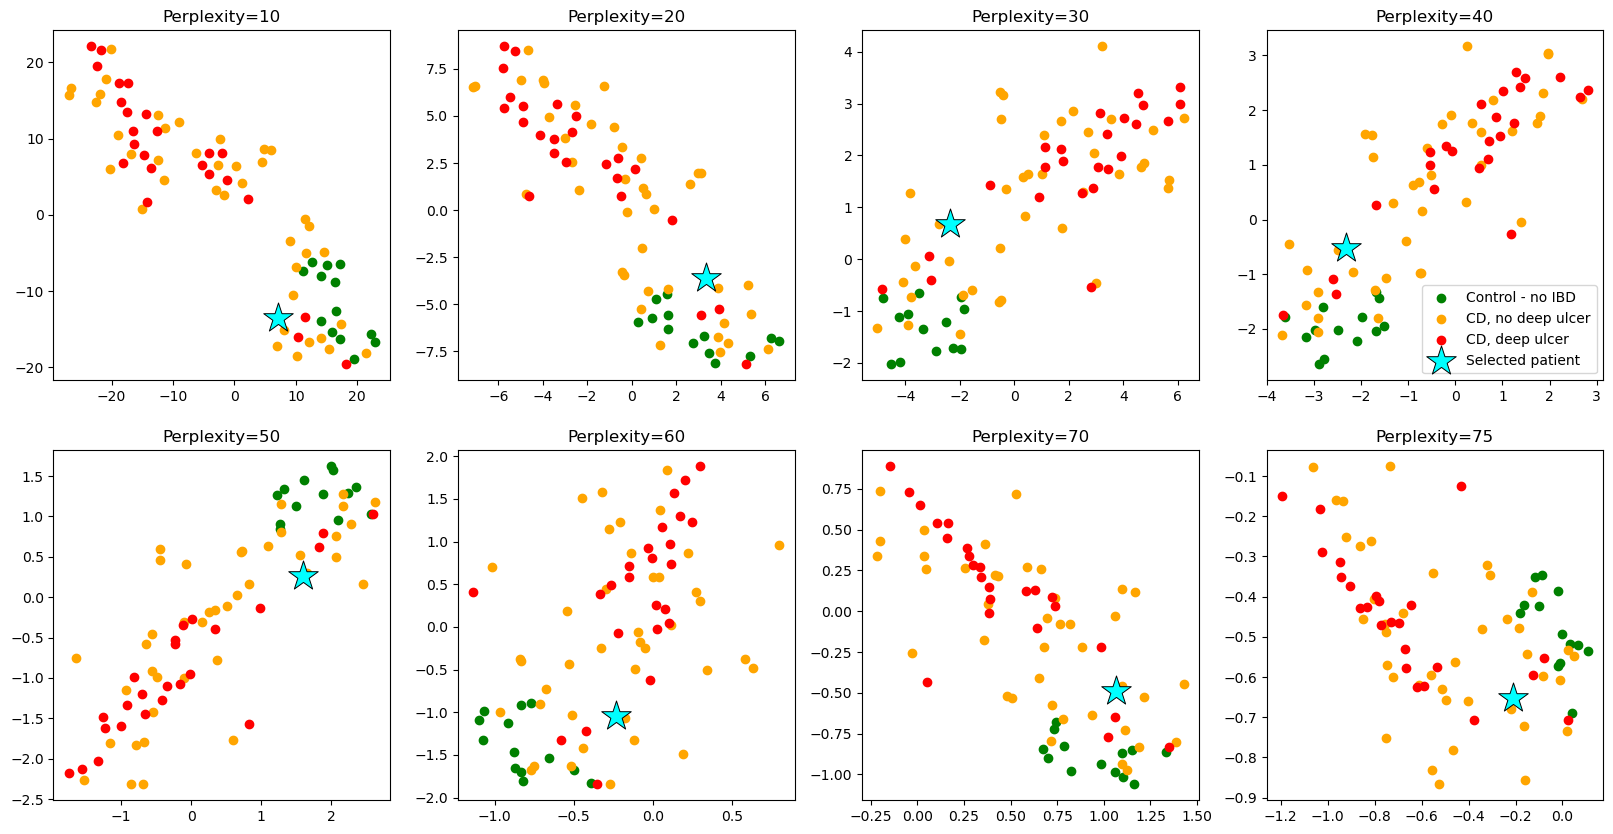

In [98]:


plot_tsne(tsne_dataset, selected_patient_idx)

### Modify gene expressions for the selected patient - 120 genes

In [99]:
test_set = x_test_scaled.copy()

selected_patient = test_set.loc[test_set.index.str.startswith(pid)]
selected_patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [100]:

# selected_patient = tsne_dataset.loc[tsne_dataset.index.str.startswith(pid)]
# selected_patient

In [101]:
with open("most_diff_genes_115", "rb") as fp:   # Unpickling
    most_diff_genes = pickle.load(fp)

most_diff_genes

['FDCSP', 'FNDC4', 'JKAMP', 'RUFY4']

In [102]:
test_set = modify_expression(pid, most_diff_genes, test_set)
test_set.loc[test_set.index.str.startswith(pid)]

dataset size (should be test): (78, 219)


,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


## Re-encoding the dataset

In [103]:
tsne_dataset, pca_x_test = encode_pca(test_set)
tsne_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,-2.947198,0.185932,0.101389,0.384208,-0.869059,0.038890,-0.352653,-0.155129,-0.035028,-0.455155,...,-0.106112,-0.269186,0.009950,0.083512,-0.140465,0.193225,0.179072,0.018266,0.014397,0.413422
105_CD_plain,-2.137259,0.996342,0.420425,-0.077963,0.409269,-0.124170,-0.438585,0.520025,0.386821,0.041907,...,0.346131,-0.037406,-0.350950,0.177862,0.269637,0.012766,-0.152461,-0.183244,0.024115,-0.073171
2_CD_plain,4.461854,-1.230253,-0.019247,1.797166,-0.240392,0.155118,-1.033455,1.031665,-0.105386,0.036644,...,-0.242571,-0.142058,-0.169804,-0.043167,0.053985,0.012293,-0.057853,0.073345,0.001752,-0.039489
184_CD_plain,0.003821,0.632336,-0.568717,-0.450686,0.366280,0.163377,-0.127619,-0.452306,0.410276,-0.434072,...,-0.139380,-0.150135,0.022972,0.001476,-0.075339,0.058156,-0.014953,0.112750,-0.082813,-0.075378
312_CD_plain,-0.673183,-0.351477,-0.516444,-0.643405,0.239442,0.084079,0.125361,-0.355189,0.338205,0.429135,...,-0.077833,0.257323,-0.214246,0.072261,0.057749,0.150106,-0.153722,0.054804,0.318017,0.054107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,-0.609229,-0.950407,0.015368,0.141221,0.785555,-0.624243,0.256934,-0.148616,-0.349497,0.098942,...,-0.060955,0.099166,-0.126782,0.204090,-0.315483,-0.097172,-0.109388,-0.298500,0.356240,-0.035464
279_CD_plain,3.538105,-1.063885,1.637338,-0.323116,-0.978556,-0.206698,0.492802,-0.341362,-0.172604,-0.112870,...,0.005217,0.022239,-0.106913,0.129582,-0.240702,0.218145,-0.079805,0.276643,-0.171940,-0.014941
179_CD_plain,-1.291112,-0.575246,-0.766237,-0.036178,0.157034,-0.148396,0.114791,0.000478,0.117857,0.297109,...,-0.184076,0.014068,-0.001758,0.107129,-0.043286,-0.144421,0.146737,0.073558,-0.208008,0.016861


## Replot tSNE

dataset size: (78, 32)


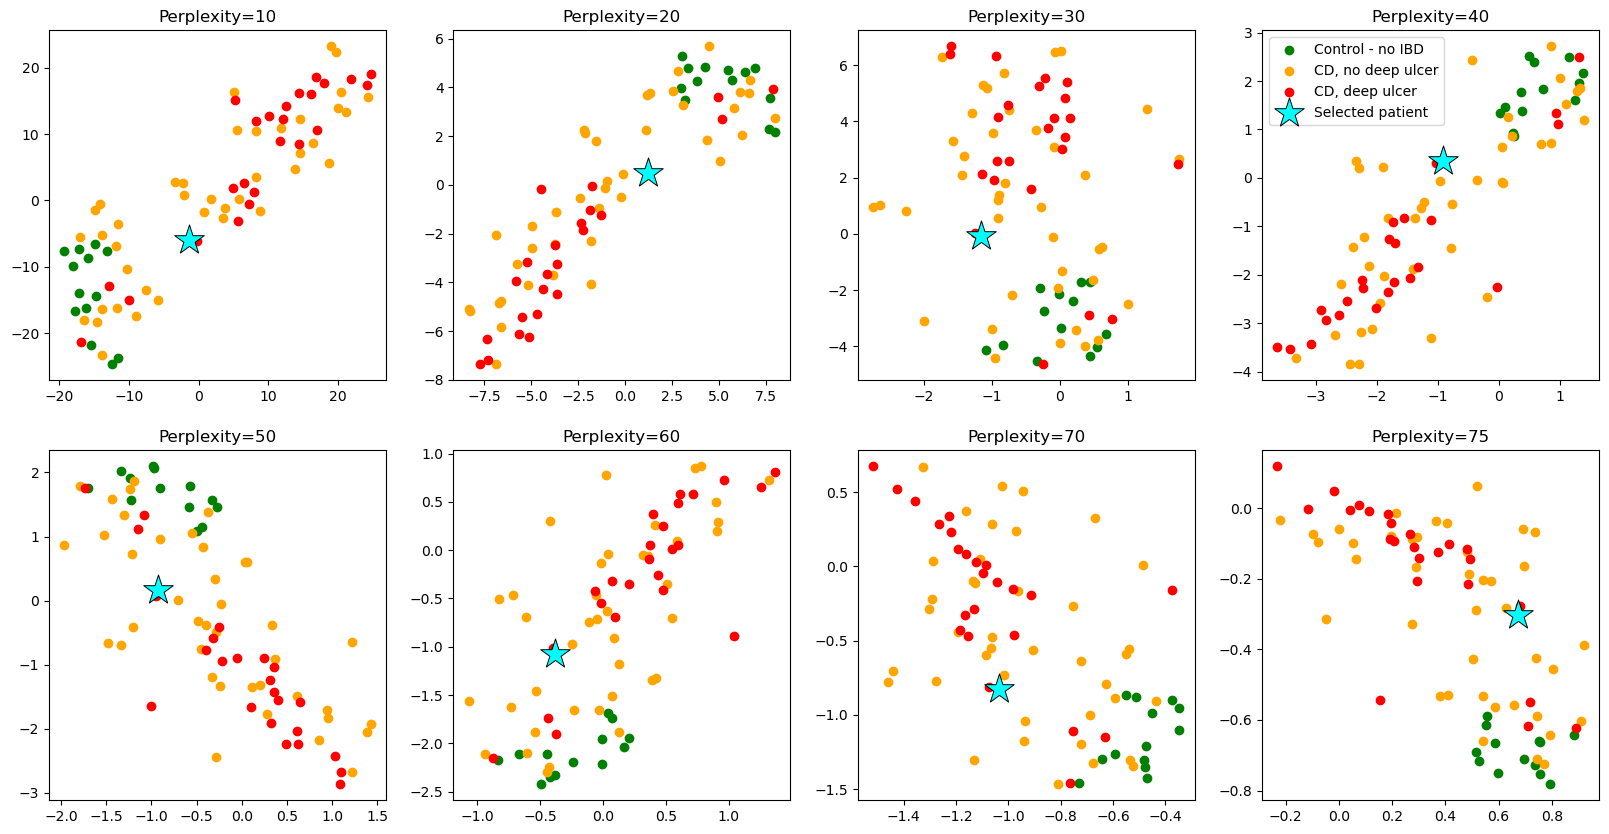

In [104]:


plot_tsne(tsne_dataset, selected_patient_idx)

Patient moves into the control cluster